<a href="https://colab.research.google.com/github/DGkurnia/cnkproject/blob/main/%5BClustering%5D_Submission_Akhir_BMLP3_Derfansyah_Guswiranata_Kurnia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Perkenalan Diri
## Nama: Derfansyah Guswiranata Kurnia
## ID Dikoding : dgkurnia
## email dikoding : weerakurnia@gmail.com

# **1. Perkenalan Dataset**


Tahap pertama, Anda harus mencari dan menggunakan dataset **tanpa label** dengan ketentuan sebagai berikut:

1. **Sumber Dataset**:  
   Dataset dapat diperoleh dari berbagai sumber, seperti public repositories (*Kaggle*, *UCI ML Repository*, *Open Data*) atau data primer yang Anda kumpulkan sendiri.
   
2. **Ketentuan Dataset**:
   - **Tanpa label**: Dataset tidak boleh memiliki label atau kelas.
   - **Jumlah Baris**: Minimal 1000 baris untuk memastikan dataset cukup besar untuk analisis yang bermakna.
   - **Tipe Data**: Harus mengandung data **kategorikal** dan **numerikal**.
     - *Kategorikal*: Misalnya jenis kelamin, kategori produk.
     - *Numerikal*: Misalnya usia, pendapatan, harga.

3. **Pembatasan**:  
   Dataset yang sudah digunakan dalam latihan clustering (seperti customer segmentation) tidak boleh digunakan.

In [1]:
#Awal
!pip install kaggle

In [2]:
#Inisiasi json
from google.colab import files

In [3]:
#upload file .json
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"derfansyahgk","key":"24be196f622b75f71753aee422847c5c"}'}

In [4]:
#pembuatan mkdir
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
#Persiapan pengunduhan dataset
!kaggle datasets download -d ankurnapa/brewery-operations-and-market-analysis-dataset

Dataset URL: https://www.kaggle.com/datasets/ankurnapa/brewery-operations-and-market-analysis-dataset
License(s): ODbL-1.0
 99% 1.05G/1.06G [00:09<00:00, 88.5MB/s]
100% 1.06G/1.06G [00:09<00:00, 119MB/s] 


# **2. Import Library**

Pada tahap ini, Anda perlu mengimpor beberapa pustaka (library) Python yang dibutuhkan untuk analisis data dan pembangunan model machine learning.

In [6]:
#Perpustakaan dataset dasar
import numpy as np
import pandas as pd
import scipy as sp
#Grafik dasar
import matplotlib.pyplot as plt
import seaborn as sns
#grafik PCA
from sklearn.decomposition import PCA

In [7]:
#Akses Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
#Bagian kedua (persiapan perpustakaan untuk protokol clustering)
from sklearn.preprocessing import RobustScaler #DBSCAN++
from sklearn.preprocessing import StandardScaler #untuk PCA
#fitur seleksi di DBSCAN
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score
from sklearn.feature_selection import SelectKBest, f_classif
#Tetangga terdekat
from sklearn.neighbors import NearestNeighbors

In [9]:
#Bagian moon, bagian serialisasi, dan DBSCAN++
#perpustakaan untuk DBSCAN++
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_score
#Moon
from sklearn.datasets import make_moons
from scipy.spatial import distance
#Bagian serialisasi
import multiprocessing as mp
from multiprocessing import Pool, Manager
import os #untuk os
import time

In [10]:
##Pelabelan dengan HDBSCAN
! pip install hdbscan
from hdbscan import HDBSCAN

In [11]:
#segmentasi dill
! pip install dill
import dill

# **3. Memuat Dataset**

Pada tahap ini, Anda perlu memuat dataset ke dalam notebook. Jika dataset dalam format CSV, Anda bisa menggunakan pustaka pandas untuk membacanya. Pastikan untuk mengecek beberapa baris awal dataset untuk memahami strukturnya dan memastikan data telah dimuat dengan benar.

Jika dataset berada di Google Drive, pastikan Anda menghubungkan Google Drive ke Colab terlebih dahulu. Setelah dataset berhasil dimuat, langkah berikutnya adalah memeriksa kesesuaian data dan siap untuk dianalisis lebih lanjut.

In [12]:
#Buka file zip
!unzip brewery-operations-and-market-analysis-dataset.zip

Archive:  brewery-operations-and-market-analysis-dataset.zip
  inflating: brewery_data_complete_extended.csv  


In [13]:
#Pembukaan file per dataset (segmentasi data)
potongan = 2500 #Potongan
#lapisan
grup = [] #per kelompok
#bentuk tanggal
formtanggal = "%d-%m-%Y" #keinginan [hari-bulan-tahun]
#iterasi untuk pembukaan perpotongan (ch menyatakan potongan)
for ch in pd.read_csv('/content/brewery_data_complete_extended.csv', chunksize=potongan):
  kopipot = ch.copy()
  #Pengubahan potongan data tanggal
  kopipot["Brew_Date"] = pd.to_datetime(kopipot["Brew_Date"], format=formtanggal,errors='coerce')
  #Pengubahan data Batch
  kopipot["Batch_ID"] = kopipot["Batch_ID"].astype(str)
  #Pembagian dataset rasio bahan dari rasio bahan
  kopipot[["Ratio1", "Ratio2", "Ratio3"]] = kopipot["Ingredient_Ratio"].str.split(":", expand=True).astype(float)
  #penempelan ke grup
  grup.append(kopipot)
#Penyatuan kembali menjadi data asli
dfull = pd.concat(grup, ignore_index=True, axis=0, sort=True, copy=True)
#lihat informasi untuk kepastian
infodfull = dfull.info()
#cetak hasil
print(infodfull)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000000 entries, 0 to 9999999
Data columns (total 23 columns):
 #   Column                        Dtype         
---  ------                        -----         
 0   Alcohol_Content               float64       
 1   Batch_ID                      int64         
 2   Beer_Style                    object        
 3   Bitterness                    int64         
 4   Brew_Date                     datetime64[ns]
 5   Brewhouse_Efficiency          float64       
 6   Color                         int64         
 7   Fermentation_Time             int64         
 8   Gravity                       float64       
 9   Ingredient_Ratio              object        
 10  Location                      object        
 11  Loss_During_Bottling_Kegging  float64       
 12  Loss_During_Brewing           float64       
 13  Loss_During_Fermentation      float64       
 14  Quality_Score                 float64       
 15  Ratio1                        f

# **4. Exploratory Data Analysis (EDA)**

Pada tahap ini, Anda akan melakukan **Exploratory Data Analysis (EDA)** untuk memahami karakteristik dataset. EDA bertujuan untuk:

1. **Memahami Struktur Data**
   - Tinjau jumlah baris dan kolom dalam dataset.  
   - Tinjau jenis data di setiap kolom (numerikal atau kategorikal).

2. **Menangani Data yang Hilang**  
   - Identifikasi dan analisis data yang hilang (*missing values*). Tentukan langkah-langkah yang diperlukan untuk menangani data yang hilang, seperti pengisian atau penghapusan data tersebut.

3. **Analisis Distribusi dan Korelasi**  
   - Analisis distribusi variabel numerik dengan statistik deskriptif dan visualisasi seperti histogram atau boxplot.  
   - Periksa hubungan antara variabel menggunakan matriks korelasi atau scatter plot.

4. **Visualisasi Data**  
   - Buat visualisasi dasar seperti grafik distribusi dan diagram batang untuk variabel kategorikal.  
   - Gunakan heatmap atau pairplot untuk menganalisis korelasi antar variabel.

Tujuan dari EDA adalah untuk memperoleh wawasan awal yang mendalam mengenai data dan menentukan langkah selanjutnya dalam analisis atau pemodelan.

In [14]:
#Proses Penyalinan data
grupc = []
#potongan file
potonganc = 2500 #potongan file per salinan
for start in range(0, len(dfull), potonganc):
    end = start + potonganc
    chunk = dfull.iloc[start:end]  # Perolehan data
    grupc.append(chunk)            # Penempelan data
#Penyatuan data salinan
dfullc = pd.concat(grupc, ignore_index=True, axis=0, sort=True, copy=True)

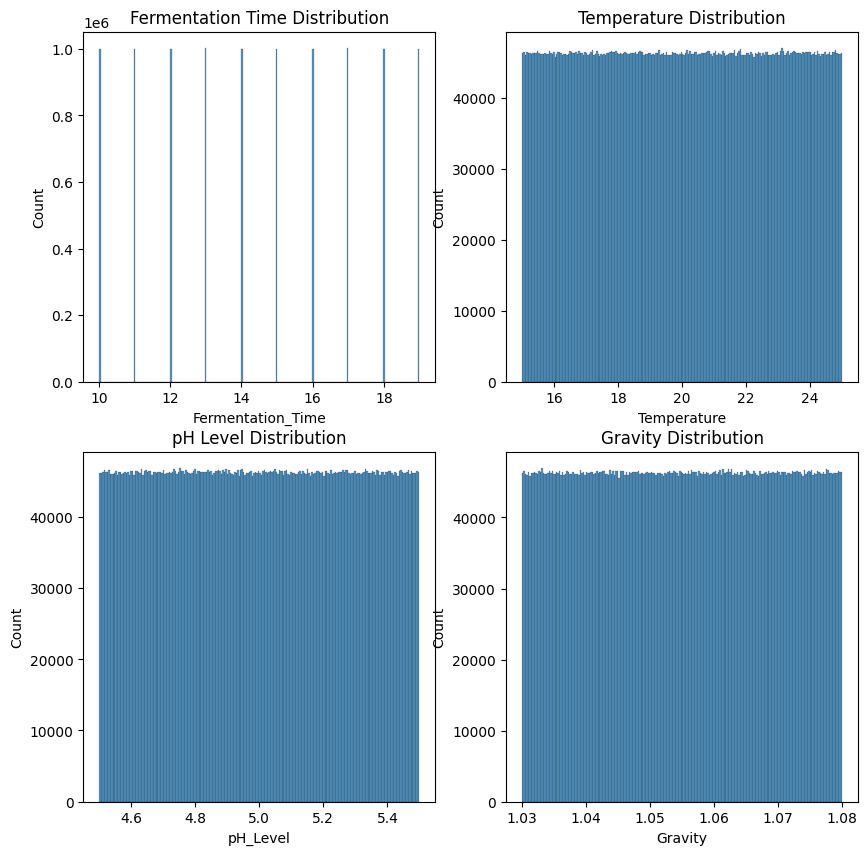

In [20]:
# Inspeksi df bafian 1
fig, axs = plt.subplots(2,2, figsize = (10,10))
sns.histplot(data = dfullc, x = "Fermentation_Time", ax = axs[0,0])
axs[0,0].set_title("Fermentation Time Distribution")
sns.histplot(data = dfullc, x = "Temperature", ax = axs[0,1])
axs[0,1].set_title("Temperature Distribution")
sns.histplot(data = dfullc, x = "pH_Level", ax = axs[1,0])
axs[1,0].set_title("pH Level Distribution")
sns.histplot(data = dfullc, x = "Gravity", ax = axs[1,1])
axs[1,1].set_title("Gravity Distribution");

In [ ]:
#Inspeksi df bagian 2


# **5. Data Preprocessing**

Pada tahap ini, data preprocessing adalah langkah penting untuk memastikan kualitas data sebelum digunakan dalam model machine learning. Data mentah sering kali mengandung nilai kosong, duplikasi, atau rentang nilai yang tidak konsisten, yang dapat memengaruhi kinerja model. Oleh karena itu, proses ini bertujuan untuk membersihkan dan mempersiapkan data agar analisis berjalan optimal.

Berikut adalah tahapan-tahapan yang perlu dilakukan, namun **tidak terbatas** pada:
1. Menghapus atau Menangani Data Kosong (Missing Values)
2. Menghapus Data Duplikat
3. Normalisasi atau Standarisasi Fitur
4. Deteksi dan Penanganan Outlier
5. Encoding Data Kategorikal
6. Binning (Pengelompokan Data)

In [ ]:
#Type your code here

# **6. Pembangunan Model Clustering**

## **a. Pembangunan Model Clustering**

Pada tahap ini, Anda membangun model clustering dengan memilih algoritma yang sesuai untuk mengelompokkan data berdasarkan kesamaan. Berikut adalah **rekomendasi** tahapannya.
1. Pilih algoritma clustering yang sesuai.
2. Latih model dengan data menggunakan algoritma tersebut.

In [ ]:
#Type your code here

## **b. Evaluasi Model Clustering**

Untuk menentukan jumlah cluster yang optimal dalam model clustering, Anda dapat menggunakan metode Elbow atau Silhouette Score.

Metode ini membantu kita menemukan jumlah cluster yang memberikan pemisahan terbaik antar kelompok data, sehingga model yang dibangun dapat lebih efektif. Berikut adalah **rekomendasi** tahapannya.
1. Gunakan Silhouette Score dan Elbow Method untuk menentukan jumlah cluster optimal.
2. Hitung Silhouette Score sebagai ukuran kualitas cluster.

In [ ]:
#Type your code here

## **c. Feature Selection (Opsional)**

Silakan lakukan feature selection jika Anda membutuhkan optimasi model clustering. Jika Anda menerapkan proses ini, silakan lakukan pemodelan dan evaluasi kembali menggunakan kolom-kolom hasil feature selection. Terakhir, bandingkan hasil performa model sebelum dan sesudah menerapkan feature selection.

In [ ]:
#Type your code here

## **d. Visualisasi Hasil Clustering**

Setelah model clustering dilatih dan jumlah cluster optimal ditentukan, langkah selanjutnya adalah menampilkan hasil clustering melalui visualisasi.

Berikut adalah **rekomendasi** tahapannya.
1. Tampilkan hasil clustering dalam bentuk visualisasi, seperti grafik scatter plot atau 2D PCA projection.

In [ ]:
#Type your code here

## **e. Analisis dan Interpretasi Hasil Cluster**

Setelah melakukan clustering, langkah selanjutnya adalah menganalisis karakteristik dari masing-masing cluster berdasarkan fitur yang tersedia.

Berikut adalah **rekomendasi** tahapannya.
1. Analisis karakteristik tiap cluster berdasarkan fitur yang tersedia (misalnya, distribusi nilai dalam cluster).
2. Berikan interpretasi: Apakah hasil clustering sesuai dengan ekspektasi dan logika bisnis? Apakah ada pola tertentu yang bisa dimanfaatkan?

In [ ]:
#Type your code here

Tulis hasil interpretasinya di sini.
1. Cluster 1:
2. Cluster 2:
3. Cluster 3:

# **7. Mengeksport Data**

Simpan hasilnya ke dalam file CSV.